# Detecting Signals in Noise using Short Fourier Transforms

Clare's F23 thesis is on the analysis of Ligo data looking for signals at moderately high frequencies with a *slow* decrease in frequency but essentially constant amplitude. The method is described in the paper by Dergachev. That is hard to understand for a non-statistician so I want to explore some of the ideas.

The basic principle seems to be to come up with a set of candidate signals, 'templates', that are then fed one at a time, along the with the signal, into a process that generates a probability score. For each template treated individually you are trying to answer the question "how much signal power is there at the frequency of interest compared to the amount of noise in that same frequency bin". Because each template has an essentially constant amplitude and frequency over the duration of the data run all your interest is centered on a single, small, frequency domain that remains constant throughput the process of studying a single template.

It is worth noting that the fundamental assumption is that the signal is hidden in noise that is significantly larger than the signal and also that the available data will be in the form of short Fourier transforms of regions of the original signal. To make life more interesting, these regions may overlap or have gaps.

NOTE The first version used a sample duration and number of samples based on powers of 2 but gave rather odd results for the single long run and for the first short run. I am trying other versions here to see if I can remove those problems.

## Why Short Fourier Transforms?

If you have a lot of data why would you want to break up into many short pieces?

First, there may be instrumental reasons. A LIGO detector is an unbelievably complex system with a ridiculous number of failure points. For this reason you may simply not be able to take data continuously. In this case you will end up with a long sequence of data but broken up into fragments with gaps between. So long as you have a stable time reference this should not cause problems. You will know the exact time relationships between all pairs of fragments. But you can't just glue them together because there are gaps and those gaps will distort the signals if you just cut them out.

Second, there is a computational cost factor. The Fourier transform is intrinsically an expensive operation. The number of multiplies and adds that it takes to compute the transforms scales (for all but the smallest numbers of samples) as the square of the number of samples (but see The FFT below). Matrix multiplications similarly scale as the square of the dimension of the matrix while determinants and matrix inversions are even more costly, scaling roughly as the cube of the dimension.

Third, and especially important for Clare, if you expect a signal with a changing frequency then the long Fourier transform will spread the signal information over as many bins as are needed to cover the frequency range of the signal. This will decrease the signal/noise contrast and make the task of identifying a signal harder. If you split the long signal into sufficient SFTs then the frequency range during the period covered by a single SFT may be made small enough that it is entirely confined within one freqency bin of the SFT. Thus each SFT will get the maximum improvement in signal to noise ratio that is possible for that signal.

### A Note on the Cost Factor

Consider a long sample containing a total of $N\times{}M$ samples (we'll see why in a minute). The computational cost for taking the Fourier transform is then 
$$C_1\simeq{}k\times{}M^{2}\times{}N^{2}+c,$$
where $k$ involves the time for each operation and the number of operations per step and $c$ is a fixed cost. Since the interesting thing here is the power we normally say that the cost is of "order $M^{2}N^{2}$, written
$$C_1\sim{}O(M^{2}N^{2})$$.

By contrast, if we split the problem up into $M$ short transforms each of length $N$ then the computational cost falls to
$$C_M\sim{}O(M\times{}N^{2}),$$
a factor of $M$ faster.

For the kind of searches mentioned in the Phys. Rev. D paper $M$ is of order 1000 so that the SFT method is about a factor 1000 faster than a "fully coherent" search on a single sample containing the same amount of data. 

#### The FFT

Thanks to James W. Cooley and John W. Tukey, there is a faster way to compute discrete Fourier transforms. Their Fast Fourier Transform (FFT) method reduces the complexity from $O(n^{2})$ to $O(n\times{}\log{n})$. For this method of performing the transforms our example would see the cost shift from
$$C_{1}'\sim{}O(MN\log(MN))=O(MN[\log(M)+\log(N)])$$
to
$$C_{M}'\sim{}O(MN\log(N))$$
which is faster by rather more than a factor of M.

For the case that Clare is studying she has taken 24 hours worth of data sampled at 1024 samples/second (sps) and split into 128 (I think) segments. That means that she is has $M=128$ and $N=691,200$ so that the cost for the full transform, using Cooley-Tukey methods is of order
$$MN\log(MN)=(88473600\log(88473600)\simeq{}7\times10^{8}$$
compared to the cost for the short transforms
$$(MN\log(N)=88473600\log(691,200)\simeq{}5\times{}10^{7}$$
So it helps, but the savings from the FFT algorithm dwafs everything else.

## What is the Penalty for using Short Fourier Transforms?

If short FFTs are so good then what are we worried about? 

First, the shorter FFTs have much poorer frequency resoution. The width of a frequency bin in the FFT is inversely proportional to the sample duration. Shorter samples means wider bins. If split a single record into 1000 shorter records then the frequency resolution of the SFTs is 1000x poorer than the original data. On the other hand, if we are trying to broaden our searches then wider bins are not necessarily a bad thing.

Second, we lose signal-to-noise with the shorter FFTs. If we take a total of $M$ runs each of $N$ samples from a single constant frequency signal with amplitude $A$ then the total power in the appropriate frequency bin from the full-length sample is $(MNA)^{2}=M^{2}N^{2}A^{2}$. However, the total power in the appropriate bin from a single short FFT is only $(NA)^{2}=N^{2}A^{2}$, a factor of $10^{6}$ less than the full sample in our example. But, you say, we have 1000 such SFTs so we can add the powers. However that will only recover $MN^{2}A^{2}$ so we are still a factor of 1000x less sensitive. Clearly the full information is still there (unlike the frequency discrimination information), we just have to figure out how to get it back.
This leads to the topic of this discussion, how do we recombine the M short FFTs so as to recover the full signal power that was present in the full-length FFT?

To answer this we will first build an example and see how good the full-length FFT is at detecting a signal in the presence of even large amounts of random noise. Then we shall see how much this suffers when we break the data up into many smaller segments and finally show how to reconstruct the original signal power.


Fourier and Noise
-----------------

The Fourier transform is instrically good at pulling signals of known frequency out of noise. We will start by looking at how this works in a simple trial system where we have a single constant amplitude sine wave buried in simple white noise.

Let's start with the obvious tools.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Now I am going to create a starting signal. It will need to be long enough to chop up and still be able to FT sensibly. To get a bare hint I will start with 10,000 samples that I can chop up into frames of 1,000 samples for transforming. I am going to assume a sample rate of 10 ksps (lower than LIGO but not hugely) so that this is going to be 1.00 seconds of data.

For simplicity I make my starting signal of unit magnitude fixed frequency of 50 Hz in the signal array.

[0.0000000e+00 9.7656250e-05 1.9531250e-04 2.9296875e-04 3.9062500e-04
 4.8828125e-04 5.8593750e-04 6.8359375e-04 7.8125000e-04 8.7890625e-04]


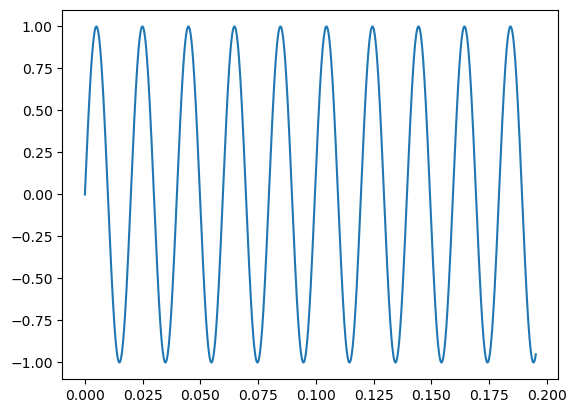

In [4]:
freq0 = 50.2
nFrame = 10
nShort = 1024
nPoint = nFrame * nShort
t = np.linspace(0, 1.0, nPoint, endpoint=False)
print(t[:10])
sig = np.sin(2 * np.pi * freq0 * t)
plt.plot(t[:2000], sig[:2000])

This will have a very simple Fourier transform.

The frequencies will range from 0 (the average value) to the Nyquist frequency,
$$f_{Ny}=\dfrac{1}{2\Delta{}t},$$
where $\Delta{}t$ is the interval between samples. For us that will be 5 kHz.

The spacing between bins is given by
$$\delta{}f=\dfrac{1}{T},$$
where $T$ is the total time for the sample. For us that will be
$$\delta{}f=\dfrac{1}{1.024\,s}=0.98\,Hz.$$

[0.0000000e+00 9.7656250e-05 1.9531250e-04 2.9296875e-04] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


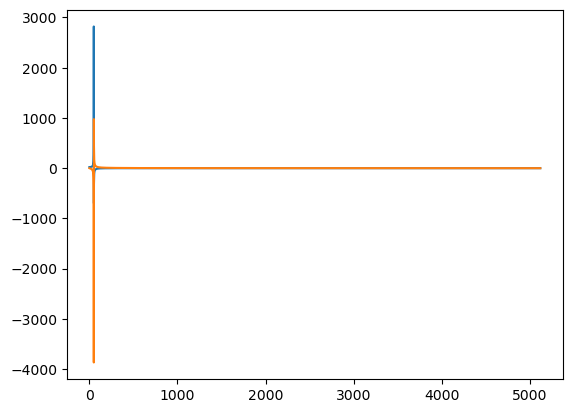

In [5]:
fft = np.fft.rfft(sig, axis=0)
freq = np.linspace(0, 1.0/(t[2]-t[0]), int(nPoint/2) + 1)
print(t[:4], freq[:10])
plt.plot(freq, np.real(fft), freq, np.imag(fft))

There is a single clear peak but its position is hard to determine because it is so low. Let's blow up the bottom region.

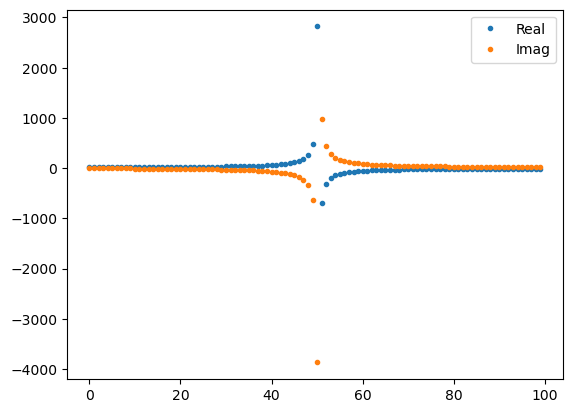

In [6]:
plt.plot(freq[:100], np.real(fft[:100]), '.', label='Real')
plt.plot(freq[:100], np.imag(fft[:100]), '.', label='Imag')
plt.legend()

We see a signal that is entirely in a bin near 50 Hz. We can find the exact cell by printing some values.

In [7]:
print(freq[45:55])
print(np.absolute(fft[45:55]))

[45. 46. 47. 48. 49. 50. 51. 52. 53. 54.]
[ 181.06418331  224.90880758  296.16873306  432.22605094  795.07015521
 4786.48017255 1200.66083423  535.43234187  345.37182361  255.34580089]


So the signal is exactly in the 51 Hz bin and has the expected value. Being confined to single cell indicates that there were an exact number of periods in the whole wave, which we can verify by looking at the end of the wave.

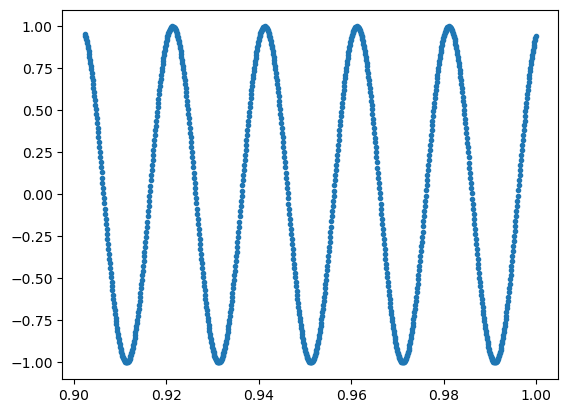

In [8]:
plt.plot(t[-1000:], sig[-1000:], '.')

Clearly we reached an integral number of periods at t=1.0.

Adding Noise in the Time Domain
-------------------------------

OK, so now what happens if we try to hide that signal in some noise?

I know from experience that our eye is good at finding sine waves even in the presence of quite a lot of noise so
let's start with noise that has the ten times the overall range of the signal so we have a 1:10 signal to noise ratio (SNR).

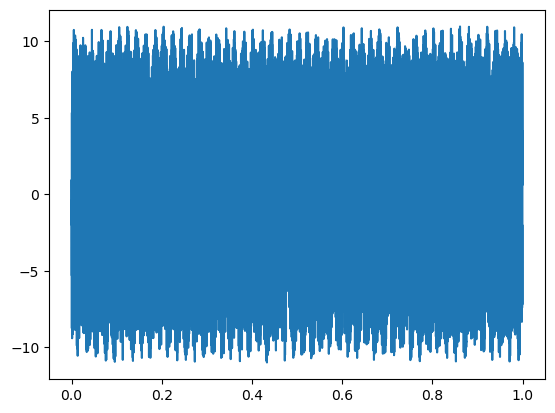

In [9]:
rng = np.random.default_rng()
noise = rng.uniform(low=-10.0, high=10.0, size=nPoint)
snp1 = sig + noise
plt.plot(t, snp1)

So at a signal-to-noise ratio of 1:10 we can just about see the signal with our eyes. Doing the same fourier analysis we get

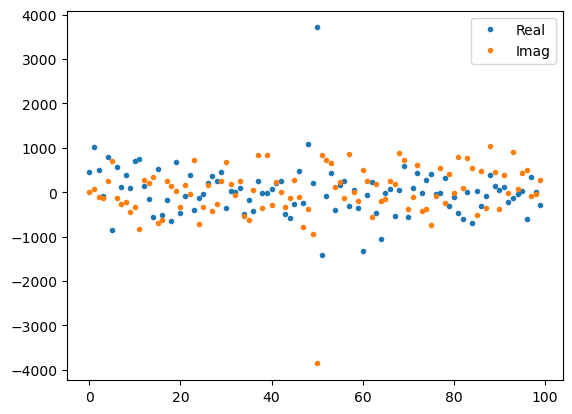

In [10]:
fftnp1 = np.fft.rfft(snp1, axis=0)
plt.plot(freq[:100], np.real(fftnp1[:100]), '.', label='Real')
plt.plot(freq[:100], np.imag(fftnp1[:100]), '.', label='Imag')
plt.legend()

or, plotting the magnitude for ease of view,

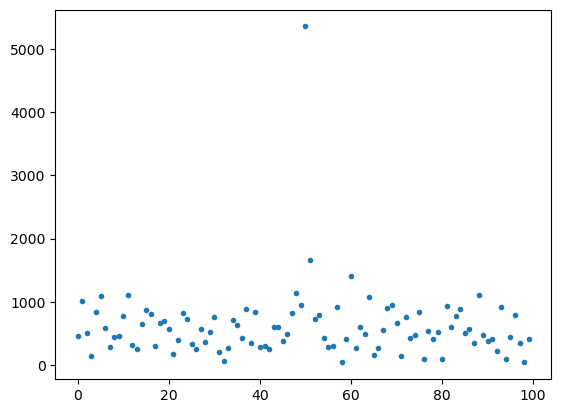

In [11]:
plt.plot(freq[:100], np.absolute(fftnp1[:100]), '.')

and we see clearly how the Fourier transform has resolved the signal well above the noise. In the signal domain we had a SNR of 1/10=0.1. In the Fourier domain we have signal+noise at around 5000 units compared to noise with a standard deviation ~500 for an SNR ~ 5. This is the power of the Fourier transform for pulling a signal out of noise.

Short Fourier Transforms
------------------------

What happens if we repeat our analysis using 10 short (1000 sample) transforms instead of the single long transform?

Well, first we are going to need a shorter frequency list since there will be only 1/10 as many frequency samples and thus the frequency bins will be 10 as wide, $9.8\,Hz$.

In [12]:
csig = sig.copy()
frames = np.zeros((nShort, nFrame))
for f in range(nFrame):
    frames[:,f] = csig[nShort*f:nShort*(f+1)]
sfts = np.fft.rfft(frames, axis=0)
sfreq = np.linspace(0, 1.0 / (t[2] - t[0]), int(nPoint/20) + 1)
print(sfreq[:10])

[ 0. 10. 20. 30. 40. 50. 60. 70. 80. 90.]


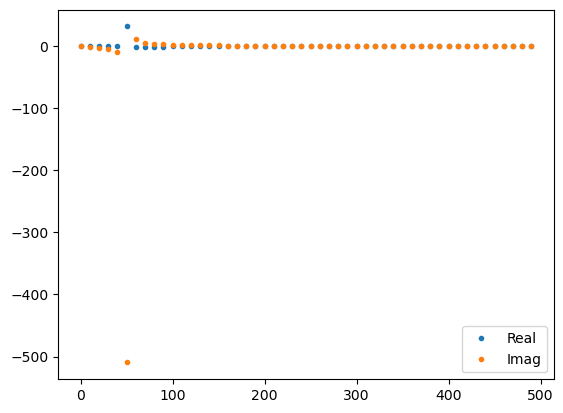

In [13]:
plt.plot(sfreq[:50], np.real(sfts[:50, 0]), '.', label='Real')
plt.plot(sfreq[:50], np.imag(sfts[:50, 0]), '.', label='Imag')
plt.legend()

The signal is mostly the 50 Hz bin but the amplitude is reduced by a factor of 10. There is now significant leakage into neighbouring frequency bins because the short sample no longer contains an integral number of waves.

For the same reason our next SFT will not look exactly like the first.

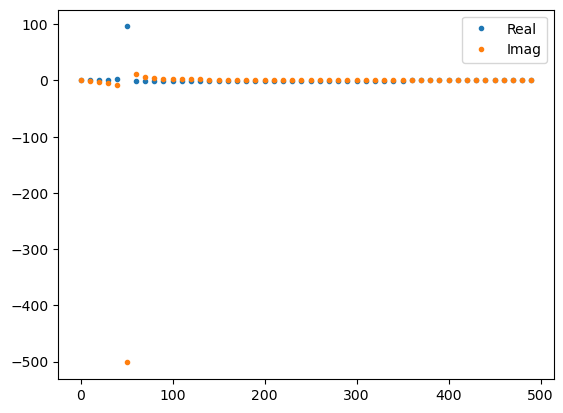

In [14]:
plt.plot(sfreq[:50], np.real(sfts[:50, 1]), '.', label='Real')
plt.plot(sfreq[:50], np.imag(sfts[:50, 1]), '.', label='Imag')
plt.legend()

Hm, the spike is in exactly the same place but the real and imaginary parts have altered significantly. We can see the cause of this if we look at the two signals.

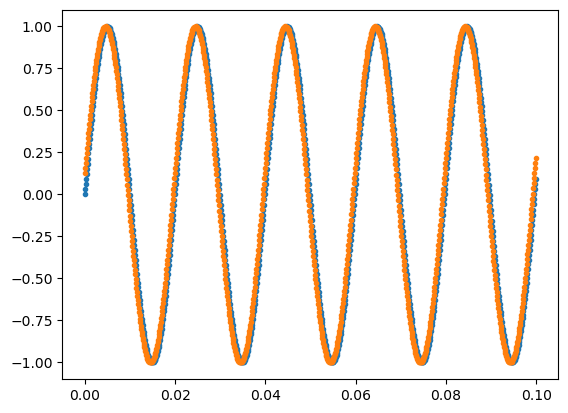

In [15]:
plt.plot(t[:nShort], frames[:,0],'.')
plt.plot(t[:nShort], frames[:,1],'.')

There we see both how the phase of the signal drifts from one sub-sample to the next and how the samples do not contain an integral number of periods. The phase drift complicates the problem of combining the results from the sub-samples to recover a low-resolution version of the full transform.

Here is what we get if we simply sum the transforms.

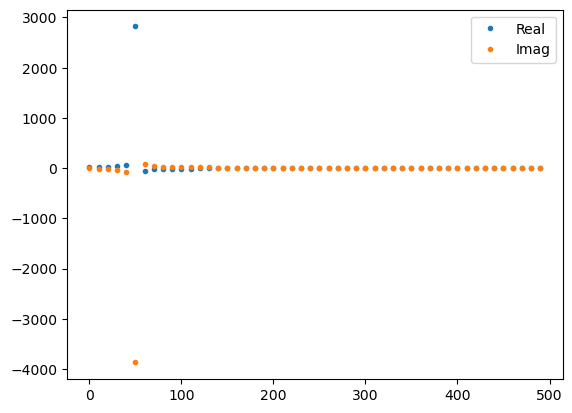

In [16]:
fsums = np.zeros(sfts.shape[0], dtype=complex)
for i in range(nFrame):
    fsums += sfts[:, i]
plt.plot(sfreq[:50], np.real(fsums[:50]), '.', label='Real')
plt.plot(sfreq[:50], np.imag(fsums[:50]), '.', label='Imag')
plt.legend()

or, plotting the magnitude again,

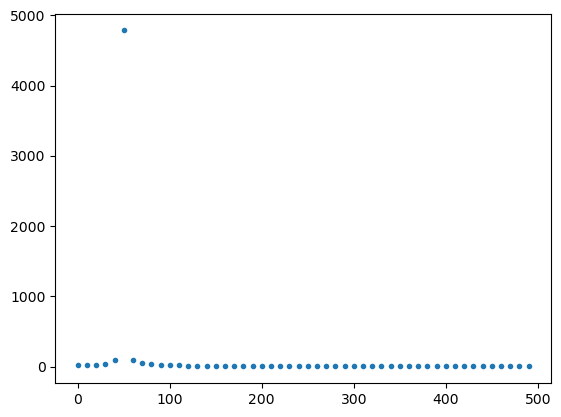

In [17]:
plt.plot(sfreq[:50], np.absolute(fsums[:50]),'.')

In this case we see no clear sign of the signal. Our adding has been subject to destructive interference and all that is left is the noise.

This is because we have been adding complex values with rather different phases and are seeing almost destructive interference. We can visualise the effect if we look at the individual 50 Hz signals in the complex plane (Argand diagram).

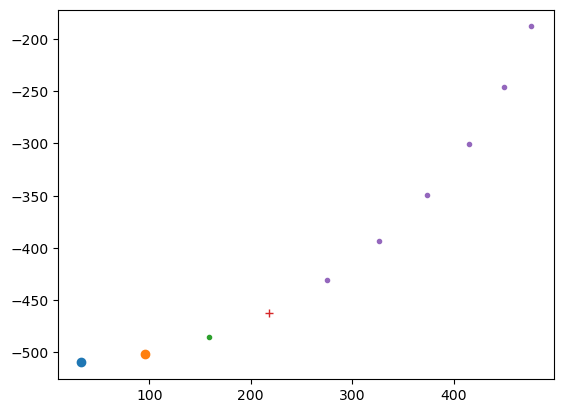

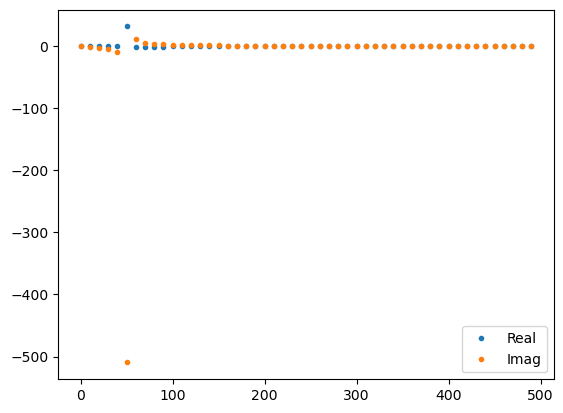

In [18]:
plt.plot(np.real(sfts[5, 0:1]), np.imag(sfts[5, 0:1]), 'o')
plt.plot(np.real(sfts[5, 1:2]), np.imag(sfts[5, 1:2]), 'o')
plt.plot(np.real(sfts[5, 2:3]), np.imag(sfts[5, 2:3]), '.')
plt.plot(np.real(sfts[5, 3:4]), np.imag(sfts[5, 3:4]), '+')
plt.plot(np.real(sfts[5, 4:10]), np.imag(sfts[5, 4:10]), '.')
plt.figure()
plt.plot(sfreq[:50], np.real(sfts[:50, 0]), '.', label='Real')
plt.plot(sfreq[:50], np.imag(sfts[:50, 0]), '.', label='Imag')
plt.legend()

We see that the points are rotating around in a circle about the origin as the phase drift grows linearly in time and that we have almost a full circle, hence the near complete cancellation.

The first point is in a somewhat odd place, as has been the case any time the first sample does not contain a complete number of periods.

Equation 78 in Riles shows us how we should sum the Fourier components from successive frames in order to get coherent summation. The phase for the i'th segment is moved forward by an amount $\phi(\omega)_{i}=\omega{}t_{i}$ so it is necessary to shift each sement's phase backward by that amount. Note that this value is different for every bin the Fourier transform since each represents a different frequency and thus a different phase shift.

Let's see it work

In [19]:
w = 2 * np.pi * freq0
w = 2 * np.pi * sfreq[5]
print(freq0, sfreq[5])
phi = np.zeros(nFrame)
ephi = np.zeros(nFrame, dtype=complex)
for i in range(nFrame):
    phi[i] = w * t[nShort * i]
    ephi[i] = np.exp(-1.0J * phi[i])
    print(phi[i], ephi[i])

50.2 50.0
0.0 (1+0j)
31.415926535897935 (1-2.328066879653148e-15j)
62.83185307179587 (1-4.656133759306296e-15j)
94.24777960769381 (1-1.7642341675360945e-14j)
125.66370614359174 (1-9.312267518612591e-15j)
157.07963267948966 (1-9.82193361864236e-16j)
188.49555921538763 (1-3.528468335072189e-14j)
219.91148575128554 (1-1.2743754478771533e-14j)
251.32741228718348 (1-1.8624535037225183e-14j)
282.7433388230814 (1+3.9163938347251765e-15j)


Next we multiply each of our 50 Hz Fourier coefficients by the phase factor and replot.

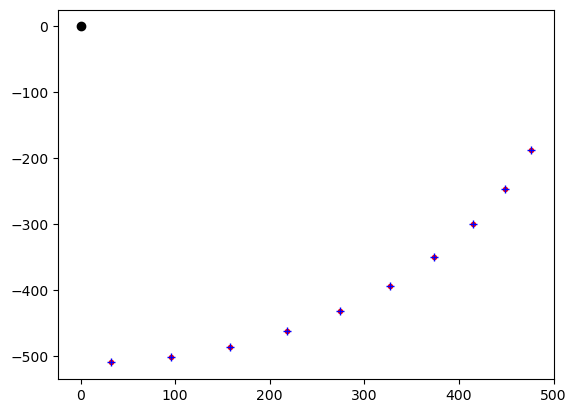

In [20]:
rft50 = sfts[5, :].copy()
plt.plot(rft50.real, rft50.imag, 'r.')
for i in range(10):
    rft50[i] = sfts[5, i] * ephi[i]
plt.plot(rft50.real, rft50.imag, 'b+')
plt.plot(0, 0, 'ko')

SO, apart from the inexplicable first point we have rotated all the points to the same angle (the orange blob). Now when we sum the Fourier coefficients and take the magnitude we get

In [21]:
print(np.absolute(np.sum(rft50)))

4786.480172553905


which is far more believable for the intensity from the full transform

In [22]:
print(np.absolute(fft[48:53]))
print(freq[48:53])

[ 432.22605094  795.07015521 4786.48017255 1200.66083423  535.43234187]
[48. 49. 50. 51. 52.]


So the quadrature sum of the last three terms is 

In [23]:
print(np.sqrt(np.conj(fft[50]) * fft[50] + np.conj(fft[51]) * fft[51] + np.conj(fft[52]) * fft[52]))

(4963.73515347382-1.4606495922759887e-14j)


So, very close. I am not clear what round off is responsible for the sliht differnce but it does not worry me much at the moment. It is immensly better than the value from the simple (non-cohered) sum

In [24]:
print(np.absolute(fsums[5]))

4786.4801725539


that we obtained from the un-cohered sum.

This illustrates the general principle of combining data from a number of short Fourier transforms to achieve the same signal-noise ratio for a constant frequency signal that you would get from doing the single long transform, albeit with only the resolution of the short transform. I don't know of a way to recover the much higher frequency resolution of the longer transform.

Once More with Noise
--------------------

Because we are able to increase the size of the signal by this coherent summation there is a worry that the noise will suffer the same increase and we won't gain anything. Fortunately, the noise is fundamentally incoherent so that the noise does not add in the same way. We can see this if we repeat the exercise using the noisy signal.

We start by splitting the noisy signal and transforming the segments.

In [25]:
csnp1 = snp1.copy()
fnp1 = np.zeros((nShort, nFrame))
for f in range(nFrame):
    fnp1[:,f] = csnp1[nShort*f:nShort*(f+1)]
sfts1 = np.fft.rfft(fnp1, axis=0)
print(sfreq[:10])

[ 0. 10. 20. 30. 40. 50. 60. 70. 80. 90.]


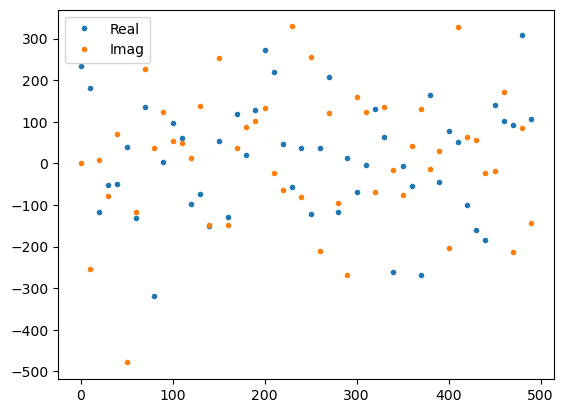

In [26]:
plt.plot(sfreq[:50], np.real(sfts1[:50, 0]), '.', label='Real')
plt.plot(sfreq[:50], np.imag(sfts1[:50, 0]), '.', label='Imag')
plt.legend()

There we see that our ability to discern the signal within the noise has been seriously hurt by shortening the segment. Comparing this with the full signal we see that our signal to noise ratio has been reduced from about 5:1 to more like 1:1.

Our task this time is rather larger than last time because we need to create phase factors for every frequency slice of every time slice.

In [27]:
full_w = 2 * np.pi * sfreq
full_phi = np.zeros((int(nPoint/20) + 1, nFrame))
full_ephi = np.zeros((int(nPoint/20) + 1, nFrame), dtype=complex)
for j in range(int(nPoint/20) + 1):
    for i in range(nFrame):
        full_phi[j, i] = full_w[j] * t[nShort * i]
        full_ephi[j, i] = np.exp(-1.0J * full_phi[j, i])

Then we form our coherent sums for every bin.

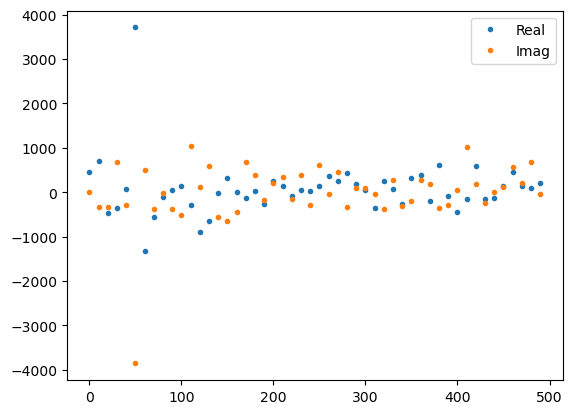

In [28]:
nf_sum = np.zeros(int(nPoint/20) + 1, dtype=complex)
for i in range (int(nPoint/20) + 1):
    for j in range(nFrame):
        nf_sum[i] += sfts1[i, j] * full_ephi[i, j]
plt.plot(sfreq[:50], np.real(nf_sum[:50]), '.', label='Real')
plt.plot(sfreq[:50], np.imag(nf_sum[:50]), '.', label='Imag')
plt.legend()

So that our coherent sum has recovered our 5:1 signal to noise ratio!

There is one BIG caveat to this. The algorithm has a curious failure mode. It works perfectly for signal frequencies that lie exactly on the frequency bin values but fails increasingly spectacularly as the signal frequency gets further from those values, giving no increase at all for a frequency mid-way between two bins. This is obviously more of a problem with smaller numbers of bins, and thus smaller original samples, but it is always going to be present.